In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
def clean(d):
    # clean and aggregate the data 
    d.District = d.District.apply(lambda x: str(x) if type(x) != str else x)
    d.loc[d['Incident Type'] == 7, 'Incident Type'] = 0
    d.loc[d['Incident Type'] != 0, 'Incident Type'] = 1
    d['Alarm Date'], d['Alarm Time'] = pd.to_datetime(df['Alarm Date']), pd.to_datetime(df['Alarm Time'])
    d['Year'], d['Month'], d['Day'] = d['Alarm Date'].dt.year, d['Alarm Date'].dt.month, d['Alarm Date'].dt.day
    d['Weekday'] =  d['Alarm Date'].dt.dayofweek
    d['Hour'], d['Minute'], d['Second'] = d['Alarm Time'].dt.hour, d['Alarm Time'].dt.minute, d['Alarm Time'].dt.second
    drop_col = ['Incident Number', 'Alarm Date', 'Alarm Time', 'Time', 'Incident Description', 'Exposure Number', 
                'Estimated Property Loss', 'Estimated Content Loss']
    d.drop(drop_col, axis=1, inplace=True)

    return d

In [3]:
def heatmap(d):
    # Draw the heatmap of correlation of these variables and find which is correlated with target
    for col in cat_cols:
        le = LabelEncoder()
        d[col] = le.fit_transform(d[col])
    corr = d.drop('Main Address', axis=1).corr()
    plt.figure(figsize=(20,13))
    sns.heatmap(corr, xticklabels=True, yticklabels=True, annot=True)
    plt.title('Heatmap')
    plt.show()
    
    return

In [4]:
def baseline(X, y):
    
    clf = LogisticRegression()       
  
    skf = KFold(n_splits=5, random_state=7)
    cv_score = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score = roc_auc_score(y_test,clf.predict(X_test))
        cv_score.append(score)

    

    print('Mean Score of cv Model:', np.mean(cv_score))
    print('Test Score of Model:', clf.score(X_test, y_test))  
    
    print('Confusion Matrix')
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('Classification Report')
    print(classification_report(y_test,clf.predict(X_test)))
    
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return
    

In [5]:
def best_model(X, y):
    
    clf = LogisticRegression(penalty='l1', C=2.78, solver='saga')       
  
    skf = KFold(n_splits=5, random_state=7)
    cv_score = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score = roc_auc_score(y_test,clf.predict(X_test))
        cv_score.append(score)

    

    print('Mean Score of cv Model:', np.mean(cv_score))
    print('Test Score of Model:', clf.score(X_test, y_test))  
    
    print('Confusion Matrix')
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('Classification Report')
    print(classification_report(y_test,clf.predict(X_test)))
    
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return

In [6]:
import category_encoders as ce

def feature_engineering(d, coder=1):
        


    num_transformer = Pipeline(steps=[('normalizer', Normalizer()), 
                                  ('scaler', StandardScaler())
                                     ])
    
    if coder == 1:
        le = LabelEncoder()
        d[cat_cols] = d[cat_cols].apply(le.fit_transform)
        #cat_transformer = Pipeline(steps=[('label', ce.OrdinalEncoder()),
        #                                 ('normalizer', Normalizer())
        #                             ])
        #preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),
        #                                       ('cat', cat_transformer, cat_cols)
          #                                            ]) 
        num_cat = num_transformer.fit_transform(d[cat_cols + num_cols])
    
    elif coder == 2:
        cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    
        preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),
                                               ('cat', cat_transformer, cat_cols)])
     
        num_cat = preprocessor.fit_transform(d[cat_cols + num_cols])
       
    elif coder == 3:
        num = num_transformer.fit_transform(d[num_cols])
        target = ce.TargetEncoder(cols=cat_cols)
        cat = target.fit_transform(d[cat_cols].reset_index(drop=True), d['Incident Type'])
        num_cat = np.concatenate((num, cat.values), axis=1)
    
   
   
    return num_cat, d['Incident Type'].values

In [29]:
import time
from sklearn.decomposition import PCA

def model_comp(x, Y):
    #pca = PCA(n_components=5)
    #x = pca.fit_transform(inp)
    lda = LinearDiscriminantAnalysis()
    x = lda.fit(x, Y).transform(x)

    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', LinearSVC()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('BOOST', AdaBoostClassifier()))
    models.append(('LOG BOOST', AdaBoostClassifier(base_estimator= LogisticRegression())))

    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        start = time.time()
        kfold = KFold(n_splits=3, random_state=7)
        cv_results = cross_val_score(model, x, Y, cv=kfold, scoring=scoring)
        end = time.time()
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        print('Time used (seconds):', end-start)

In [9]:
df = pd.read_csv('E://springboard//capstone_project_1//clean_data/clean_data.csv', encoding='ISO-8859-1', 
                  index_col=[0], dtype={'Zip':'category'})

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df1 = clean(df).copy()
cat_cols = ['Neighborhood', 'Zip', 'Property Use', 'Property Description', 'WindDir', 
                'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Weekday']

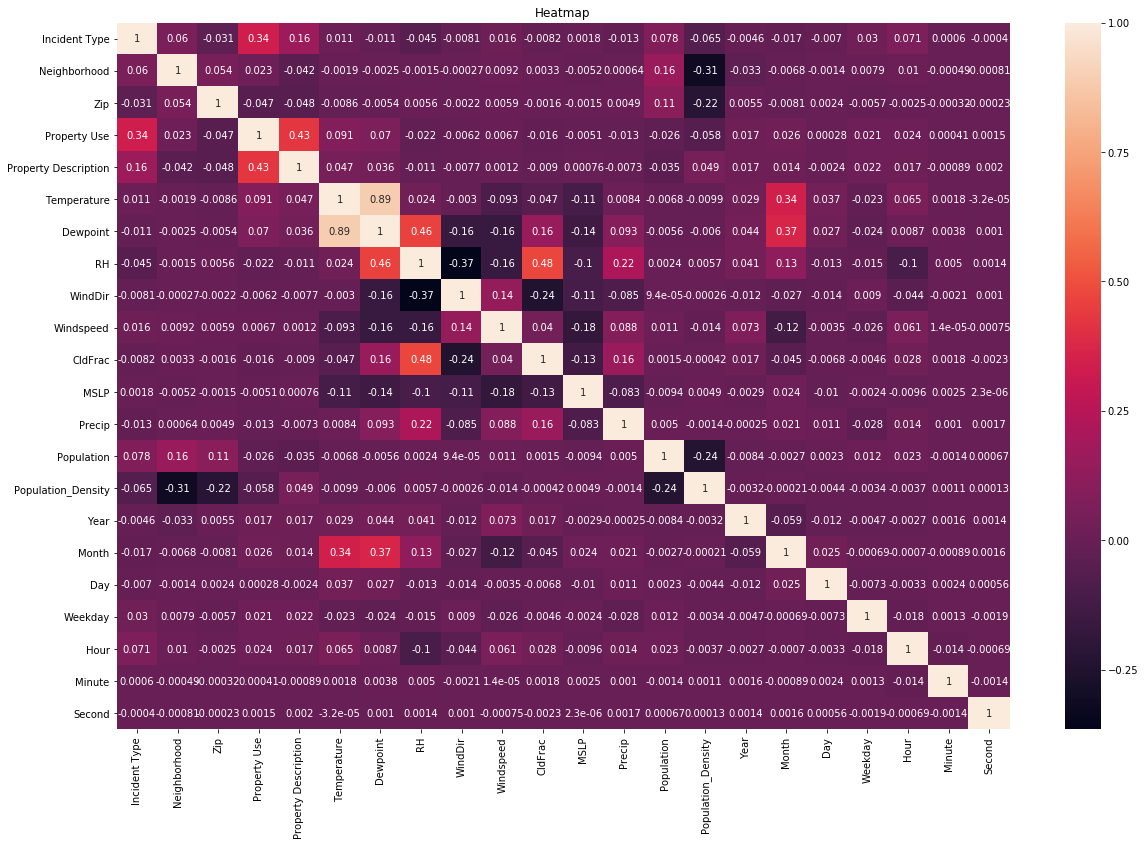

In [10]:
heatmap(df1)

In [13]:
# filter out the correlated variables to target
cat_cols = ['Neighborhood', 'Property Use', 'Property Description', 'Weekday']
num_cols = ['Temperature', 'Windspeed', 'RH', 'Precip','Population', 'Population_Density', 'Hour']
df1[cat_cols] = df1[cat_cols].astype(str)

Mean Score of cv Model: 0.5096949604016725
Test Score of Model: 0.6540646270263862
Confusion Matrix
[[ 1475 33292]
 [ 1726 64734]]
Classification Report
              precision    recall  f1-score   support

           0       0.46      0.04      0.08     34767
           1       0.66      0.97      0.79     66460

   micro avg       0.65      0.65      0.65    101227
   macro avg       0.56      0.51      0.43    101227
weighted avg       0.59      0.65      0.54    101227



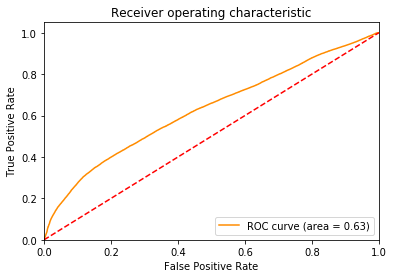

In [42]:
# Build up the baseline
baseline(X, y)

In [11]:
# Use Labelencoder to feature engineering categorical and compare four classification models
X, y = feature_engineering(df1, 1)


In [12]:


model_comp(X, y)

LR: 0.671021 (0.009045)
Time used (seconds): 4.214932203292847
NB: 0.666259 (0.009477)
Time used (seconds): 1.150937795639038
SVM: 0.669355 (0.009409)
Time used (seconds): 222.29526686668396
LDA: 0.668759 (0.009536)
Time used (seconds): 2.703687906265259
BOOST: 0.687943 (0.009440)
Time used (seconds): 70.80593085289001
LOG BOOST: 0.668512 (0.009330)
Time used (seconds): 90.47503018379211


In [14]:
# Use dummies to feature engineering categorical variables and compare four models.
X_one, y_one = feature_engineering(df1, 2)


In [15]:
pca = PCA(n_components=100)
pca_results = pca.fit(X_one)

In [17]:
model_comp(pca_result, y_one)

LR: 0.711583 (0.006165)
Time used (seconds): 77.13627934455872
NB: 0.690258 (0.003373)
Time used (seconds): 10.843556642532349
SVM: 0.710618 (0.005534)
Time used (seconds): 595.7101771831512
LDA: 0.710908 (0.005501)
Time used (seconds): 22.722564697265625
BOOST: 0.709449 (0.007172)
Time used (seconds): 688.0870189666748
LOG BOOST: 0.694552 (0.009784)
Time used (seconds): 265.38897228240967


In [30]:
#Use target encoder to feature engineering categorical variables and compare four models
X_t, y_t = feature_engineering(df1, 3)
model_comp(X_t, y_t)

LR: 0.703140 (0.005251)
Time used (seconds): 0.9371039867401123
NB: 0.703407 (0.004819)
Time used (seconds): 0.30004310607910156
SVM: 0.702514 (0.005539)
Time used (seconds): 106.23926329612732
LDA: 0.703239 (0.005213)
Time used (seconds): 0.4298536777496338
RF: 0.635668 (0.007107)
Time used (seconds): 42.81188344955444
BOOST: 0.709084 (0.004552)
Time used (seconds): 28.347148656845093
LOG BOOST: 0.702850 (0.005348)
Time used (seconds): 49.59318161010742


In [16]:
# Tune Hyperparameter of Adaboost Classifier
n_estimators = [10, 50, 100]
lr = [0.1, 1, 10]
LDA = LinearDiscriminantAnalysis()
adaboosting = AdaBoostClassifier(base_estimator=LogisticRegression())
pipe_boosting = Pipeline(steps=[('lda', LDA), ('Boosting', adaboosting)])
estimator = GridSearchCV(pipe_boosting,
                         dict(Boosting__n_estimators=n_estimators,
                             Boosting__learning_rate=lr))
estimator.fit(X_one, y_one)
best_param = estimator.best_params_ 
print(best_param)

{'Boosting__learning_rate': 0.1, 'Boosting__n_estimators': 10}


In [17]:
estimator.best_score_

0.7127587410514946

In [33]:
estimator.cv_results_

{'mean_fit_time': array([20.12220192, 30.75085576, 47.0153625 , 18.49488052, 28.8439575 ,
        41.42835665, 17.43160168, 29.59565568, 45.03986677]),
 'mean_score_time': array([0.42833694, 0.85900982, 1.5024964 , 0.40134819, 0.82632979,
        1.42256196, 0.39739291, 0.81755892, 1.43259764]),
 'mean_test_score': array([0.71275874, 0.71262373, 0.71251836, 0.71249531, 0.71227139,
        0.71227797, 0.66629566, 0.66629566, 0.66629566]),
 'mean_train_score': array([0.71527948, 0.71467852, 0.71421586, 0.71422245, 0.71393102,
        0.71393432, 0.66629566, 0.66629566, 0.66629566]),
 'param_Boosting__learning_rate': masked_array(data=[0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_Boosting__n_estimators': masked_array(data=[10, 50, 100, 10, 50, 100, 10, 50, 100],
              mask=[False, False, False, False, False, False, False, False

In [31]:
def best_model(X, y):
    # Calculate the optimal model and show the results
    LDA = LinearDiscriminantAnalysis()
    adaboosting = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=10, learning_rate=0.1)
    
    clf = Pipeline(steps=[('lda', LDA), ('Boosting', adaboosting)])
    
    skf = KFold(n_splits=10, random_state=7)
    cv_score = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score = roc_auc_score(y_test,clf.predict(X_test))
        cv_score.append(score)

    

    print('Mean Score of cv Model:', np.mean(cv_score))
    print('Test Score of Model:', clf.score(X_test, y_test))  
    
    print('Confusion Matrix')
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('Classification Report')
    print(classification_report(y_test,clf.predict(X_test)))
    
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return



Mean Score of cv Model: 0.6299699127145011
Test Score of Model: 0.7134812961011591
Confusion Matrix
[[ 3888  6838]
 [ 1863 17779]]
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.36      0.47     10726
           1       0.72      0.91      0.80     19642

   micro avg       0.71      0.71      0.71     30368
   macro avg       0.70      0.63      0.64     30368
weighted avg       0.71      0.71      0.69     30368



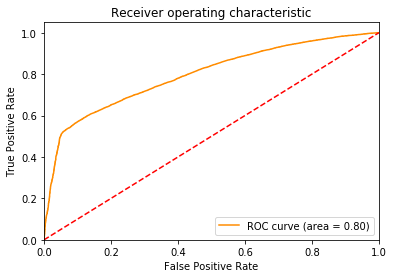

In [27]:
best_model(X_one, y_one)